This notebook has been used ot produce most of the figures in the documentation.  It is also used to derive the relaiotnship between inital momentum and inverse of helix diameter.

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
import pickle as pkl
from tqdm import tqdm_notebook as tqdm

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
from trackml.dataset import load_event
pd.options.display.max_columns = 200

In [2]:
data_l = []
for i in range(10, 30):
    event = '../input/train_1/event0000010%d' % i
    print('event:', event)
    hits, cells, particles, truth = load_event(event)
    data = hits
    data = data.merge(truth, how='left', on='hit_id')
    data = data.merge(particles, how='left', on='particle_id')
    data0 = data.copy()
    data['rv'] = np.sqrt(data.vx**2 + data.vy**2)
    data = data[data.weight > 0]
    data = data[data.rv < 1].copy()
    data['event_id'] = i

    data.x = data.tx - data.vx
    data.y = data.ty - data.vy
    data.z = data.tz - data.vz
    data['absz'] = np.abs(data.z)
    data = data.sort_values(by=['particle_id', 'absz']).reset_index(drop=True)
    
    data['pt'] = np.sqrt(data.px ** 2 + data.py ** 2)
    
    # compute alpha0 from inital momentum an dfirst hit coordinates, see Appendiux A in documentation
    
    data['rc'] = (data.x**2 + data.y**2)
    data['rt'] = np.sqrt(data.rc)
    data['first_x'] = data.groupby('particle_id').x.transform('first')
    data['first_y'] = data.groupby('particle_id').y.transform('first')
    data['first_rc'] = data.groupby('particle_id').rc.transform('first')
    
    data['alpha0'] = np.abs( (data.px * data.first_y - data.py * data.first_x) / 
                             (data.pt * data.first_rc)
                           ) 

    # compute deviaiton between theoretical angle and observed angle
    data['phi'] = np.arctan2(data.y, data.x)
    data.phi *= -data.q
    
    data['phi0'] = np.arctan2(data.py, data.px)
    data.phi0 *= -data.q
    
    data['theta0'] = data.phi - data.phi0
    data['theta0'] = data.theta0 % (np.pi)
    data= data[np.abs(data.rt * data.alpha0) < 1].copy()

    data['theta0_th'] = np.arcsin(data.rt * data.alpha0)
    data['theta_ratio'] = (data.theta0 / data.theta0_th)
    
    
    data_l.append(data)

data = pd.concat(data_l, axis=0)
data = data.sample(frac=1, random_state=0)
    

event: ../input/train_1/event000001010
event: ../input/train_1/event000001011
event: ../input/train_1/event000001012
event: ../input/train_1/event000001013
event: ../input/train_1/event000001014
event: ../input/train_1/event000001015
event: ../input/train_1/event000001016
event: ../input/train_1/event000001017
event: ../input/train_1/event000001018
event: ../input/train_1/event000001019
event: ../input/train_1/event000001020
event: ../input/train_1/event000001021
event: ../input/train_1/event000001022
event: ../input/train_1/event000001023
event: ../input/train_1/event000001024
event: ../input/train_1/event000001025
event: ../input/train_1/event000001026
event: ../input/train_1/event000001027
event: ../input/train_1/event000001028
event: ../input/train_1/event000001029


Text(0,0.5,'alpha0')

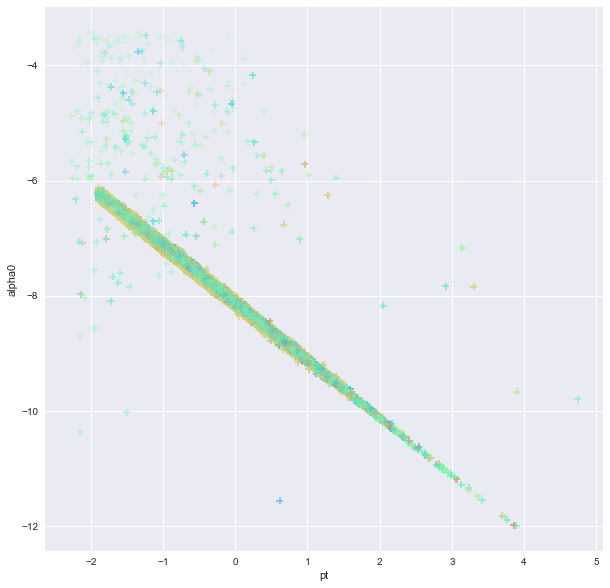

In [3]:
data1 = data
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(np.log(data1.pt), np.log(data.alpha0), 
           c=data1.z, cmap='rainbow', marker='+', alpha=0.1)
ax.set_xlabel('pt')
ax.set_ylabel('alpha0')

In [4]:
from sklearn.linear_model import LinearRegression

[[-0.99830335]]
[-8.113018]


Text(0,0.5,'alpha0')

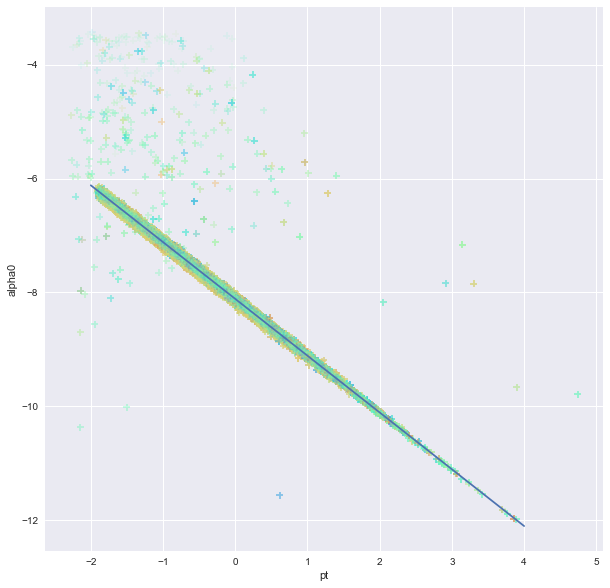

In [5]:
lr = LinearRegression(fit_intercept=True)

lr.fit(np.log(data[['pt']]), np.log(data[['alpha0']]))

print(lr.coef_)

print(lr.intercept_)

data1 = data
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(np.log(data1.pt), np.log(data.alpha0), 
           c=data1.z, cmap='rainbow', marker='+', alpha=0.1)
x = np.linspace(-2, 4, 100).reshape(-1, 1)
y = lr.predict(x)
ax.plot(x, y)
ax.set_xlabel('pt')
ax.set_ylabel('alpha0')

Text(0,0.5,'pr*alpha0')

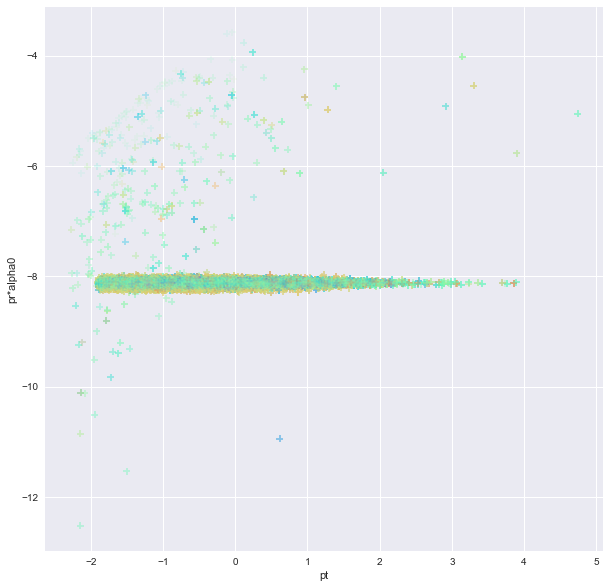

In [6]:
data1 = data
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(np.log(data1.pt), np.log(data1.pt * data.alpha0),
           c=data1.z, cmap='rainbow', marker='+', alpha=0.1)
ax.set_xlabel('pt')
ax.set_ylabel('pr*alpha0')

[[0.00012532]]
[-8.115432]


Text(0,0.5,'pt*alpha0')

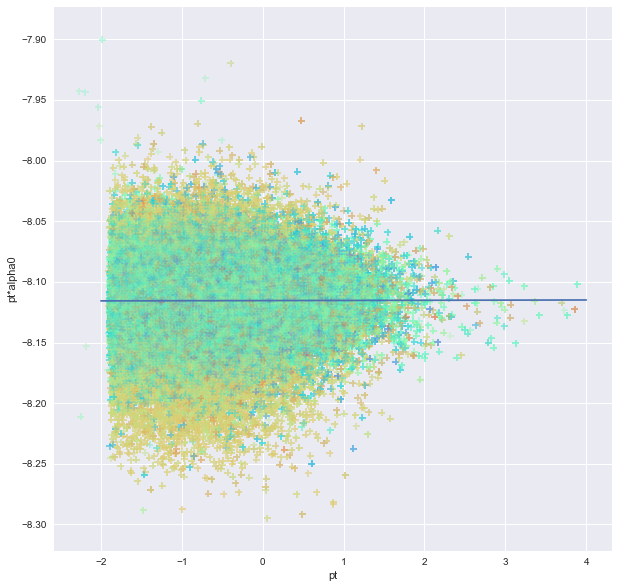

In [7]:
data['gamma'] = data.pt * data.alpha0
data1 = data[(np.log(data.gamma) > -8.3) & (np.log(data.gamma) < -7.9) ]

lr = LinearRegression(fit_intercept=True)

lr.fit(np.log(data1[['pt']]), np.log(data1[['gamma']]))

print(lr.coef_)

print(lr.intercept_)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(np.log(data1.pt), np.log(data1.gamma),
           c=data1.z, cmap='rainbow', marker='+', alpha=0.1)
x = np.linspace(-2, 4, 100).reshape(-1, 1)
y = lr.predict(x)
ax.plot(x, y)
ax.set_xlabel('pt')
ax.set_ylabel('pt*alpha0')

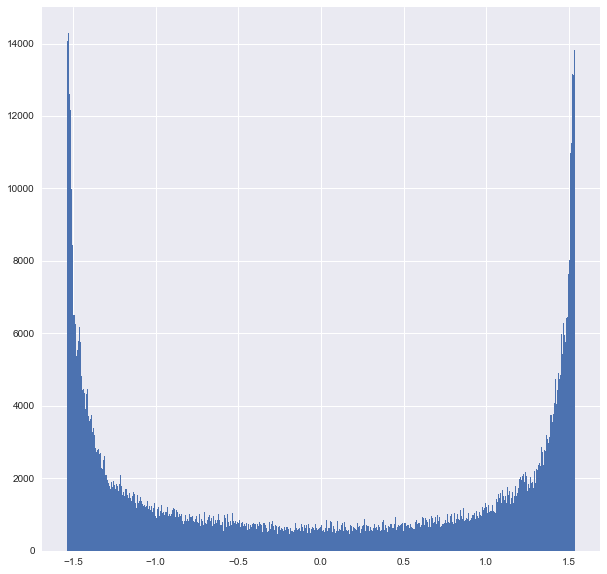

In [8]:
data['zr'] = np.arctan2(data.pz, data.pt)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
_ = ax.hist((data.zr), bins=1000, log=False)

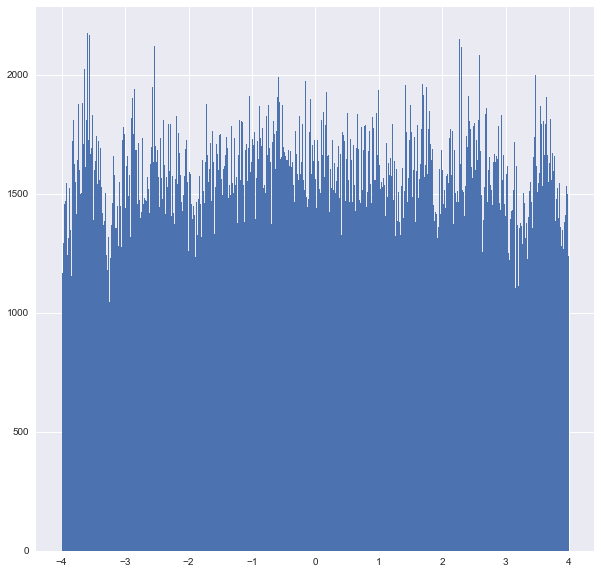

In [9]:
data['zr'] = np.arcsinh(data.pz / data.pt)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
_ = ax.hist((data.zr), bins=1000, log=False)

Text(0,0.5,'theta_ratio')

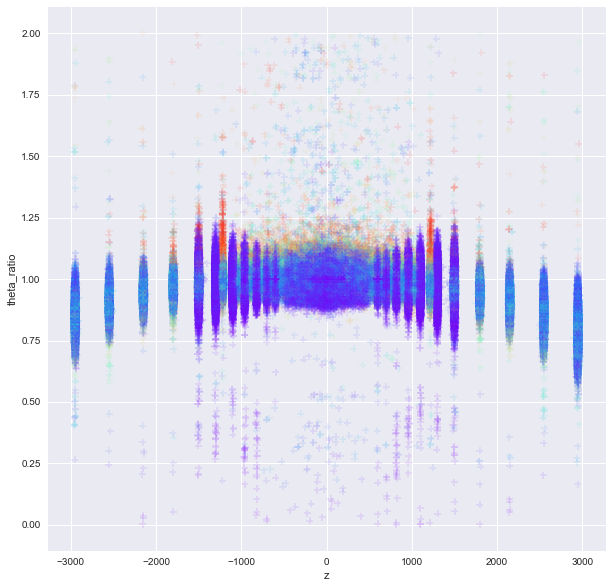

In [10]:
data1 = data[(data.theta0 < np.pi / 2) & (data.theta_ratio < 2)]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(data1.z, data1.theta_ratio, 
           c=data1.theta0, cmap='rainbow', marker='+', alpha=0.1)
ax.set_xlabel('z')
ax.set_ylabel('theta_ratio')

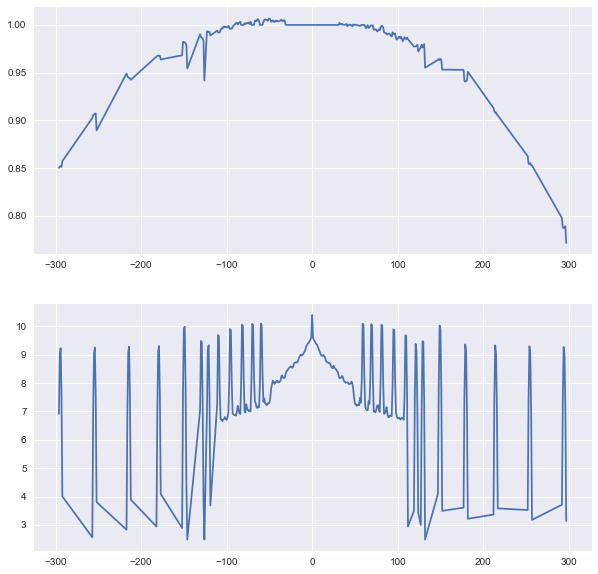

In [22]:
data['zz'] = (data.z / 10).astype('int')

data1 = data[(data.theta0 < np.pi / 2) & (np.abs(data.theta_ratio) < 2)]
df = data1.groupby('zz').agg({'theta_ratio':'median', 'hit_id':'count'})
df = df[df.hit_id > 10]
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(df.theta_ratio)
ax[1].plot(np.log(df.hit_id))

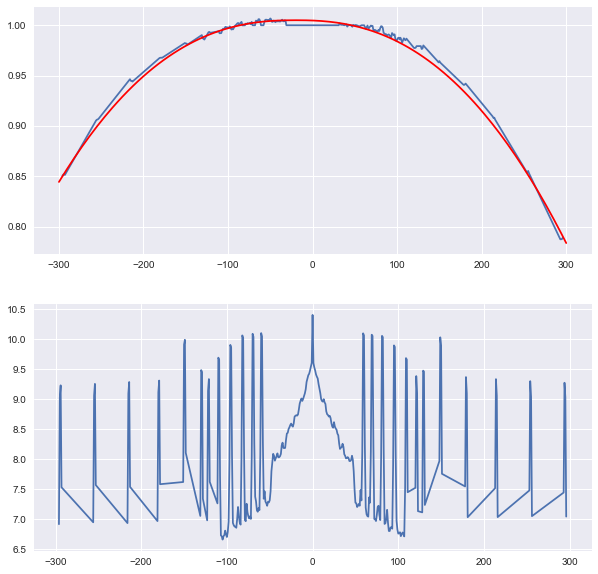

In [10]:
data['zz'] = (data.z / 10).astype('int')

data1 = data[(data.theta0 < np.pi / 2) & (np.abs(data.theta_ratio) < 2)]
df = data1.groupby('zz').agg({'theta_ratio':'median', 'hit_id':'count'})
df = df[np.log(df.hit_id) > 6]
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot(df.theta_ratio)
x = np.linspace(-300, 300, 200)
y = 1 - (np.abs(x + 20) / 600)**2.4 + 0.005
ax[0].plot(x, y, c='r')
ax[1].plot(np.log(df.hit_id))


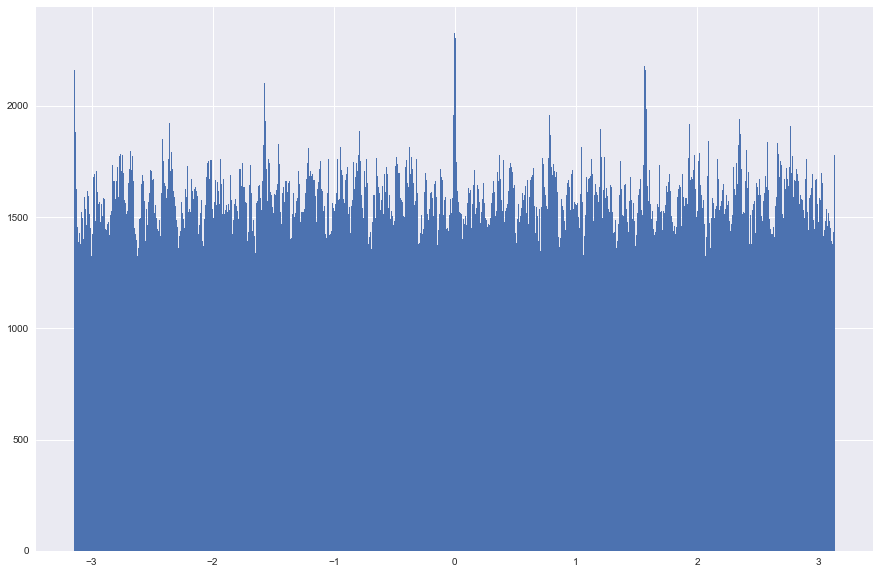

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
_ = ax.hist((data.phi), bins=1000, log=False)